In [1]:
import sys, os

# Add utility_scripts in the current path so that they can be imported directly just like in interactive mode
sys.path.append(os.path.abspath("../usr/lib/"))
for script_folder in os.listdir("../usr/lib/"):
    sys.path.append(os.path.abspath("../usr/lib/"+script_folder))

In [2]:
from statistics import mean
import pickle

import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from lastquerytransformer import Riiid
from riiidutils import RiiidDataset, riiid_collate_fn

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Introduction

Le fichier train.csv comprend un peu plus de 100 millions de lignes.  
Il y a un peu moins de 400 mille user_id uniques.  
Le modèle utilisé dans ce notebook prend en entrée une série par utilisateur.

# Features utilisées
Pour chaque question de la série d'apprentissage d'un utilisateur quelconque  

1. Question ID: correspond à content_id (lorsque l'élément est une question).
2. Question part: correspond à part dans question.csv pour l'élément dont question_id correspondant à content_id
3. Answer correctness: valeur de answered_correctly de l'exemple (ou target encoding de la question ?)
4. Current question elapsed time: prior question de la question suivante.
5. Timestamp difference: current question timestamp - timestamp of the last question from the same user

# Chargement des données et instanciation des datasets

In [4]:
with open('../input/riiid-sequences/users_y.pickle', 'rb') as f:
    users_y = pickle.load(f)
with open('../input/riiid-sequences/users_cat.pickle', 'rb') as f:
    users_cat = pickle.load(f)
with open('../input/riiid-sequences/users_cont.pickle', 'rb') as f:
    users_cont = pickle.load(f)

In [5]:
#users_y = users_y[:2000]
#users_cat = users_cat[:2000]
#users_cont = users_cont[:2000]

In [6]:
cat_train, cat_val, cont_train, cont_val, y_train, y_val = train_test_split(users_cat, users_cont, users_y, test_size=.05)

## Batches
Dynamic Padding: ajout de padding batch par batch pour avoir une même longueur de séquence dans chaque batch.  
Uniform size batching: on trie les utilisateurs par longueur de séquence, afin d'avoir des longueurs plus proches dans chaque batch  

Afin de mettre en œuvre ces deux stratégies on va par simplicité trier au préalable et conjointement les listes batch_cat, batch_cont et batch_y par longueur des séquences dans batch_cat/batch_cont (c'est RiiidDataset qui s'en charge). Le DataLoader utilisera une fonction collate_fn permettant d'ajouter du padding dynamiquement batch par batch.

In [7]:
train_dataset = RiiidDataset(cat_train, cont_train, y_train)
val_dataset = RiiidDataset(cat_val, cont_val, y_val)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=riiid_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=riiid_collate_fn)

# Modèle
Pour le modèle, l'auteur s'est inspiré de la solution arrivée 3è à la compétition [Data Science bowl 2019](https://www.kaggle.com/c/data-science-bowl-2019/discussion/127891)  
La procédure de création des embeddings est expliquée, on suppose que l'auteur s'est basé dessus.
## Embeddings
On utilise un embedding catégoriel pour les 3 premières variables et un embedding continu pour les 2 dernières.
Contrairement à la solution du lien ci-dessus on utilise un embedding catégoriel par variable catégorielle plutôt qu'un embedding commun, comme recommandé [ici](https://discuss.pytorch.org/t/categorical-embeddings-can-i-only-have-1-categorical-column-per-embedding-layer/104681/3)

In [9]:
maximums = {'question_id': 13523, 'part': 7, 'answered_correctly': 3}
model = Riiid(maximums).to(device)

# Training

In [10]:
LEARNING_RATE = 1e-6
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [11]:
def evaluate(model, iterator, criterion):
    model.eval()
    losses = []
    accuracies = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            x_cat = batch['cat'].to(device)
            x_cont = batch['cont'].to(device)
            y = batch['y'].to(device)

            ypred = model(x_cat, x_cont).squeeze(0).squeeze(1)
            loss = criterion(ypred, y)

            losses.append(float(loss))
            accuracies.append((torch.round(torch.sigmoid(ypred)) == y).float().mean().item())

    return mean(losses), mean(accuracies)

In [12]:
accuracies = []
losses = []
val_accuracies = []
val_losses = []

In [13]:
epochs = 25
# we use 2 writers so we can have the train and val scalars on the same plots
LOG_DIR = "tensorboard"
train_writer = SummaryWriter(os.path.join(LOG_DIR, "train"))
val_writer = SummaryWriter(os.path.join(LOG_DIR, "val"))

for e in range(epochs):
    model.train()
    e_accuracies = []
    e_losses = []
    print("Epoch ", e)
    for batch in train_loader:
        x_cat = batch['cat'].to(device)
        x_cont = batch['cont'].to(device)
        y = batch['y'].to(device)

        # squeeze() will remove the 3 dimensions if batch_size = 1
        ypred = model(x_cat, x_cont).squeeze(0).squeeze(1)
        loss = criterion(ypred, y)
        with torch.no_grad():
            e_losses.append(float(loss))
            e_accuracies.append((torch.round(torch.sigmoid(ypred)) == y).float().mean().item())

        loss.backward()
        optimizer.step()
    losses.append(mean(e_losses))
    accuracies.append(mean(e_accuracies))
    val_l, val_acc = evaluate(model, val_loader, criterion)
    val_accuracies.append(val_acc)
    val_losses.append(val_l)
    print("Loss:", losses[-1])
    print("Accuracy:", accuracies[-1])
    print("Validation loss:", val_losses[-1])
    print("Validation accuracy:", val_accuracies[-1])
    train_writer.add_scalar("Loss", losses[-1], e)
    train_writer.add_scalar("Accuracy", accuracies[-1], e)
    val_writer.add_scalar("Loss", val_losses[-1], e)
    val_writer.add_scalar("Accuracy", val_accuracies[-1], e)

train_writer.close()
val_writer.close()

Epoch  0
Loss: 0.692019964268333
Accuracy: 0.5163157894736842
Validation loss: 0.680260181427002
Validation accuracy: 0.6
Epoch  1
Loss: 0.6773727049325642
Accuracy: 0.6026315789473684
Validation loss: 0.6557287836074829
Validation accuracy: 0.71
Epoch  2
Loss: 0.667632610797882
Accuracy: 0.6031578947368421
Validation loss: 0.6499064421653747
Validation accuracy: 0.64
Epoch  3
Loss: 0.658488177500273
Accuracy: 0.6031578947368421
Validation loss: 0.6392673468589782
Validation accuracy: 0.65
Epoch  4
Loss: 0.6508709195413087
Accuracy: 0.6147368421052631
Validation loss: 0.631427766084671
Validation accuracy: 0.65
Epoch  5
Loss: 0.6458349731721376
Accuracy: 0.618421052631579
Validation loss: 0.6363161396980286
Validation accuracy: 0.64
Epoch  6
Loss: 0.6416098061360811
Accuracy: 0.6242105263157894
Validation loss: 0.6393248617649079
Validation accuracy: 0.66
Epoch  7
Loss: 0.638500887124162
Accuracy: 0.6247368421052631
Validation loss: 0.6519372701644898
Validation accuracy: 0.66
Epoch  8

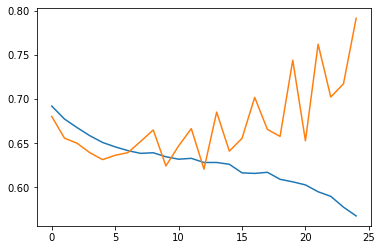

In [14]:
plt.plot(losses)
plt.plot(val_losses)

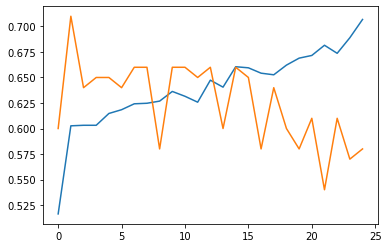

In [15]:
plt.plot(accuracies)
plt.plot(val_accuracies)